In [43]:
# 导入库函数
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.interpolate import interp1d

In [44]:
###############################LPP算法函数######################################
#####################计算自适应epsilon graph####################
def compute_adaptive_neighbors(Data):
    n = Data.shape[1]  # 样本点的数量
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) 
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    np.savetxt('sorted_distances.csv', sorted_distances, delimiter=',')
    adaptive_neighbors = np.zeros((n, 1))
    # 对每行距离进行插值和求导
    for i in range(n):
        # 对距离进行插值，生成连续的函数
        f = interp1d(np.arange(n), sorted_distances[i], kind='linear')
        #coefficients = np.polyfit(np.arange(n), sorted_distances[i], deg=5)  # 使用6次多项式拟合
        #f = np.poly1d(coefficients)  # 构建多项式函数
        # 求导
        df = np.gradient(f(np.arange(n)))  # 计算函数的导数
        # 寻找导数为1的位置
        idx = np.where(df <= 1)[0][0]
        # 将索引保存为每个数据点的邻居数量
        adaptive_neighbors[i] = idx
    return adaptive_neighbors, sorted_distances, distances

# 根据adaptive_neighbors中每一行的邻居数量和sorted_distances对每个数据点构建epsilon graph
def adaptive_epsilon_graph(Data, method, k):
    adaptive_neighbors, sorted_distances, distances = compute_adaptive_neighbors(Data)
    n = Data.shape[1]  
    adaptive_epsilon_adjacency_matrix = np.zeros((n, n)) 
    if method == "Adaptive epsilon": # 计算自适应epsilon graph，不管k值
        for i in range(n):
            indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
            adaptive_epsilon_adjacency_matrix[i, indices] = 1
            adaptive_epsilon_adjacency_matrix[indices, i] = 1
        return adaptive_epsilon_adjacency_matrix, distances
    elif method == "KNN + Adaptive epsilon": # 以k值为邻居数的阈值，小于k值的邻居数使用adaptive epsilon graph，大于k值的邻居数使用knn graph
        for i in range(n):
            if adaptive_neighbors[i] <= k:
                indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
                adaptive_epsilon_adjacency_matrix[i, indices] = 1
                adaptive_epsilon_adjacency_matrix[indices, i] = 1
            else:
                indices = np.argsort(distances[i])[:k]
                adaptive_epsilon_adjacency_matrix[i, indices] = 1
                adaptive_epsilon_adjacency_matrix[indices, i] = 1
        return adaptive_epsilon_adjacency_matrix, distances


#####################计算自适应epsilon graph####################

#####################计算经典knn graph####################
def knn_graph(Data, method, k):
    n = Data.shape[1]  
    knn_adjacency_matrix = np.zeros((n, n))  
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1))
    if method == "Average-KNN-distances-based epsilon":
        return distances
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances
#####################计算经典knn graph####################

#####################计算epsilon graph####################
def compute_avg_radius(n, distances): 
    radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(distances[:, i])  # 修改计算每个数据点的平均邻域半径的方式
        radius[i] = avg_radius
    return radius

def compute_knn_average_radius(sorted_distances, k):
    avg_knn_distances = np.mean(sorted_distances[:, 1:k+1], axis=1)  # 计算每个数据点的前k个距离的平均值作为半径
    return avg_knn_distances
#####################计算epsilon graph####################

def compute_neighborhood_matrix(Data, method, k):
    n = Data.shape[1]  # 获取样本点的数量
    if method == "KNN":
        knn_adjacency_matrix, distances = knn_graph(Data, method, k)
        return knn_adjacency_matrix, distances
    elif method == "Adaptive epsilon":
        adaptive_epsilon_adjacency_matrix, distances = adaptive_epsilon_graph(Data, method, k)
        return adaptive_epsilon_adjacency_matrix, distances
    elif method == "Average-KNN-distances-based epsilon":
        epsilon_adjacency_matrix = np.zeros((n, n))
        distances = knn_graph(Data, method, k)
        sorted_distances = np.sort(distances, axis=1)
        radius = compute_knn_average_radius(sorted_distances, k)
        for i in range(n):
            neighbors = np.where(distances[:, i] <= radius[i])[0]  
            epsilon_adjacency_matrix[i, neighbors] = 1
            epsilon_adjacency_matrix[neighbors, i] = 1
        return epsilon_adjacency_matrix, distances
    elif method == "KNN + Adaptive epsilon":
        epsilon_adjacency_matrix, distances = adaptive_epsilon_graph(Data, method, k)
        return epsilon_adjacency_matrix, distances

def construct_weight_matrix(Data, method, k,t):
    n = Data.shape[1]  
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    similarity_matrix = np.exp(-distances ** 2 / t)
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]
    #Weight_matrix += np.exp(-distances ** 2 / t) 如果修正那么有用那对邻域的改进还有什么意义？？
    return Weight_matrix

In [45]:
def PCA(X, n_components):
    # 计算数据矩阵的均值
    mean = np.mean(X, axis=0)
    # 中心化数据矩阵
    X_centered = X - mean
    # 计算数据矩阵的协方差矩阵
    covariance_matrix = np.cov(X_centered, rowvar=False)
    # 计算协方差矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 对特征向量按特征值从大到小排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # 选取前n_components个特征向量
    principal_components = sorted_eigenvectors[:, :n_components]
    # 返回投影矩阵和均值向量
    return principal_components

In [46]:
# MLDA算法函数

# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    print("类别数量：", num_classes)
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    print("每个类别的样本数：", num_samples_per_class)
    num_features = train_data.shape[1]  # 每个样本的特征维度
    print("每个样本的特征维度：", num_features)
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵

# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵


In [47]:
def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    plt.show()

In [48]:
# 计算每个类别的权重矩阵，度矩阵和拉普拉斯矩阵
def DLPP_LPP(train_data, method, k, t):
    train_data = train_data.T
    Weight_matrix = construct_weight_matrix(train_data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    return Laplacian_matrix, train_data


In [49]:
# 计算每个类别的均值矩阵
def DLPP_MLDA(train_data, train_labels):
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    return classes_means.T

In [50]:
def LPP(Data, d, method, k, t):
    Data = Data.T
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    print("LPP拉普拉斯矩阵形状：", Laplacian_matrix.shape)
    objective_value = np.dot(np.dot(Data, Laplacian_matrix), Data.T)  # 计算目标函数
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [51]:
import scipy

def MLDA(train_data, train_labels, faceshape, d):
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)
    
    W_value = np.dot(Sw.T, Sb)  # 计算投影矩阵W
    print(W_value.shape)  # 输出投影矩阵W的形状

    # 计算广义特征值问题的特征值和特征向量，提取前d个最大特征值对应的特征向量
    eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((faceshape[0] * faceshape[1]-d),(faceshape[0] * faceshape[1]-1)))  # 计算特征值和特征向量
    print('Done LDA selected eigenvectors computing')  # 输出提示信息
    print('LDA特征脸形状：', eigen_vectors.shape)
    ShowEigenface(eigen_vectors, faceshape)
    return eigen_vectors

In [52]:
def DLPP(train_data, train_labels, d, lpp_method, k, t):
    # Step 1: 使用MLDA进行特征提取
    F = DLPP_MLDA(train_data, train_labels)
    # Step 2: 使用LPP进行特征提取
    L, X = DLPP_LPP(train_data, lpp_method, k, t)
    # Step 3: 计算权重矩阵B
    num_classes = len(np.unique(train_labels))  # 计算训练集中的类别数
    B = np.zeros((num_classes, num_classes))  # 初始化权重矩阵B
    # 遍历每对类别，计算其对应的权重
    for i in range(num_classes):  # 遍历每个类别
        for j in range(num_classes):  # 再次遍历每个类别
            if i != j:  # 如果类别不相同
                fi = F[:,i]  # 获取第i个类别的平均脸
                fj = F[:,j]  # 获取第j个类别的平均脸
                # 计算第i类别和第j类别平均脸之间的欧氏距离，并将其应用于高斯核函数，计算权重
                B[i, j] = np.exp(-np.linalg.norm(fi - fj) ** 2 / t)
    # Step 4: 计算E和H矩阵
    E = np.diag(np.sum(B, axis=1))
    H = E - B

    # Step 5: 分式
    denominator = np.dot(np.dot(F, H), F.T) + 1e-10  # 添加一个微小的非零值，以避免除以零
    numerator = np.dot(np.dot(X, L), X.T)
    objective_value = numerator / denominator

    # Step 6: 求解广义特征值问题的特征值和特征向量
    # eigs用于稀疏矩阵，eigh用于稠密矩阵
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]  
    selected_eigenvectors = eigenvectors.real[:, selected_indices] 
    return F, L, B, objective_value, selected_eigenvectors

In [53]:
# 导入库函数
import numpy as np
from os import listdir, path, remove
from cv2 import imread, resize, INTER_AREA, IMREAD_GRAYSCALE
from sklearn.model_selection import train_test_split
from PIL import Image

# 读取数据集
def read_ORL_UMIST_yalefaces_images(dataset_dir, target_size=None):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = path.join(class_path, file_name)  # 图像文件路径
            if file_name.endswith('.gif'):  # 如果文件格式为.gif
                # 使用PIL库打开.gif文件
                with Image.open(file_path) as img:
                    # 转换为灰度图像
                    img = img.convert('L')
                    # 保存为.pgm格式
                    pgm_file_path = file_path.replace('.gif', '.pgm')
                    img.save(pgm_file_path)
                    # 读取.pgm文件并继续后续处理
                    img = imread(pgm_file_path, IMREAD_GRAYSCALE)
                    # 如果指定了目标尺寸，则缩放图像
                    if target_size is not None:
                        img = resize(img, target_size, interpolation=INTER_AREA)
                    remove(pgm_file_path)  # 删除临时保存的.pgm文件
            elif file_name.endswith('.tif'):  # 如果文件格式为.tif
                # 使用PIL库打开.tif文件
                with Image.open(file_path) as img:
                    # 转换为灰度图像
                    img = img.convert('L')
                    # 保存为.pgm格式
                    pgm_file_path = file_path.replace('.tif', '.pgm')
                    img.save(pgm_file_path)
                    # 读取.pgm文件并继续后续处理
                    img = imread(pgm_file_path, IMREAD_GRAYSCALE)
                    # 如果指定了目标尺寸，则缩放图像
                    if target_size is not None:
                        img = resize(img, target_size, interpolation=INTER_AREA)
                    remove(pgm_file_path)        
            else:
                img = imread(file_path, IMREAD_GRAYSCALE)  # 读取灰度图像
                # 如果指定了目标尺寸，则缩放图像
                if target_size is not None:
                    img = resize(img, target_size, interpolation=INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            if not faceshape:
                faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分(按顺序划分)
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    num_classes = len(np.unique(labels))  # 类别数
    train_samples_per_class = int(train_test_split_ratio * num_samples / num_classes)  # 每个类别的训练样本数
    
    train_indices = []
    test_indices = []
    for i in range(1, num_classes + 1):  # 对每个类别
        class_indices = np.where(labels == i)[0]  # 获取当前类别的索引
        train_indices.extend(class_indices[:train_samples_per_class])  # 将前面部分作为训练集
        test_indices.extend(class_indices[train_samples_per_class:])  # 将后面部分作为测试集
    
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]
    
    return train_data, train_labels, test_data, test_labels

from sklearn.model_selection import train_test_split
def split(data, labels, train_test_split_ratio, state):
    classes = np.unique(labels)
    train_indices = []
    test_indices = []
    for i in range(min(classes), max(classes) + 1):  # Iterate over each class
        class_indices = np.where(labels == i)[0]  # Get indices for the current class
        # Split the samples of the current class into training and testing sets
        train_idx, test_idx = train_test_split(class_indices, test_size=(1 - train_test_split_ratio), train_size=train_test_split_ratio, random_state=state)
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]
    
    return train_data, train_labels, test_data, test_labels

In [54]:
def test_image(i, train_labels, test_labels, query, weight_matrix):
    query = query.reshape(-1, 1)
    # 计算测试图像权重与数据集中每个人脸权重的欧氏距离
    euclidean_distances = np.linalg.norm(weight_matrix - query, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = True
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    return flag

In [55]:
#from sklearn.datasets import load_digits
#digits = load_digits()
#data = digits.data
#labels = digits.target
#images = digits.images

d = 40
k = 5
t = 161000
#t=200000
lpp_method = 'knn' # 'knn'或'epsilon'

dataset = "yalefaces"
data, labels, faceshape = read_ORL_UMIST_yalefaces_images(dataset, target_size=(32, 32))
print("数据形状:", data.shape)

train_data, train_labels, test_data, test_labels = split(data, labels, 0.5, 0)
print("训练集X形状：", train_data.shape)
print("训练集标签形状：", train_labels.shape)
print("测试集X形状：", test_data.shape)
print("测试集标签形状：", test_labels.shape)

数据形状: (165, 1024)
训练集X形状： (75, 1024)
训练集标签形状： (75, 1)
测试集X形状： (90, 1024)
测试集标签形状： (90, 1)


In [56]:

data_by_pca = PCA(train_data, d)
print("PCA训练数据主成分形状:", data_by_pca.shape)
test_data_by_pca = PCA(test_data.T, d)
print("PCA测试数据主成分形状:", test_data_by_pca.shape)


# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, train_labels, test_labels, test_data_by_pca[i], data_by_pca.T)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print("识别率：", rate)


PCA训练数据主成分形状: (1024, 40)
PCA测试数据主成分形状: (90, 40)


IndexError: index 967 is out of bounds for axis 0 with size 75

In [ ]:
dlpp_eigenvectors = DLPP(train_data, train_labels, d, lpp_method, k, t)
print("DLPP变换矩阵A形状:", dlpp_eigenvectors.shape)
dlpp_weight_matrix = dlpp_eigenvectors.T @ train_data.T
print("DLPP子空间Y形状:", dlpp_weight_matrix.shape)

dlpp_test_data = dlpp_eigenvectors.T @ test_data.T
print("DLPP子空间的测试集形状:", dlpp_test_data.shape)

ShowEigenface(dlpp_eigenvectors, faceshape)

# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, train_labels, test_labels, dlpp_test_data[:,i], dlpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print("识别率：", rate)


类别数量： 15
每个类别的样本数： 5
每个样本的特征维度： 1024


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_3604\1017425255.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
lpp_eigenvectors = LPP(train_data, d, lpp_method, k, t)
lpp_weight_matrix = lpp_eigenvectors.T @ train_data.T
print("LPP变换矩阵A形状:", lpp_eigenvectors.shape)
print("LPP子空间Y形状:", lpp_weight_matrix.shape)
lpp_test_data = lpp_eigenvectors.T @ test_data.T
ShowEigenface(lpp_eigenvectors, faceshape)


# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, train_labels, test_labels, lpp_test_data[:,i], lpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print("识别率：", rate)


In [ ]:
eigen_vectors = MLDA(train_data, train_labels, faceshape, d)
print("MLDA变换矩阵A形状:", eigen_vectors.shape)
ShowEigenface(eigen_vectors, faceshape)

In [ ]:
def ShowALLEigenface(dlpp_eigenvectors, lpp_eigenvectors, data_by_pca, eigen_vectors, faceshape):
    # 显示前3个DLPP特征脸、前3个LPP特征脸、前3个PCA特征脸、前3个MLDA特征脸
    fig, axes = plt.subplots(3, 4, figsize=(12, 12))
    
    # 显示DLPP特征脸
    for i in range(3):
        axes[i, 0].imshow(dlpp_eigenvectors[:, i].reshape(faceshape), cmap="gray")
        axes[i, 0].set_title("DLPP Eigenface {}".format(i+1))
    
    # 显示LPP特征脸
    for i in range(3):
        axes[i, 1].imshow(lpp_eigenvectors[:, i].reshape(faceshape), cmap="gray")
        axes[i, 1].set_title("LPP Eigenface {}".format(i+1))
    
    # 显示PCA特征脸
    for i in range(3):
        axes[i, 2].imshow(data_by_pca[:, i].reshape(faceshape), cmap="gray")
        axes[i, 2].set_title("PCA Eigenface {}".format(i+1))
    
    # 显示MLDA特征脸
    for i in range(3):
        axes[i, 3].imshow(eigen_vectors[:, i].reshape(faceshape), cmap="gray")
        axes[i, 3].set_title("MLDA Eigenface {}".format(i+1))
    
    # 在下方的标题里显示d, k,t lpp_method等参数,标题字号为12并加粗
    fig.suptitle("d={}, k={}, t={}, method={}, dataset=ORL".format(d, k, t, lpp_method), fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
ShowALLEigenface(dlpp_eigenvectors, lpp_eigenvectors, data_by_pca, eigen_vectors,faceshape)


In [ ]:
# 读取数据集
def read_ORL_UMIST_YALE_images(dataset_dir, target_size=None):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = path.join(class_path, file_name)  # 图像文件路径
            if file_name.endswith('.gif'):  # 如果文件格式为.gif
                # 使用PIL库打开.gif文件
                with Image.open(file_path) as img:
                    # 转换为灰度图像
                    img = img.convert('L')
                    # 保存为.pgm格式
                    pgm_file_path = file_path.replace('.gif', '.pgm')
                    img.save(pgm_file_path)
                    # 读取.pgm文件并继续后续处理
                    img = imread(pgm_file_path, IMREAD_GRAYSCALE)
                    # 如果指定了目标尺寸，则缩放图像
                    if target_size is not None:
                        img = resize(img, target_size, interpolation=INTER_AREA)
                    remove(pgm_file_path)  # 删除临时保存的.pgm文件
            elif file_name.endswith('.tif'):  # 如果文件格式为.tif
                # 使用PIL库打开.tif文件
                with Image.open(file_path) as img:
                    # 转换为灰度图像
                    img = img.convert('L')
                    # 保存为.pgm格式
                    pgm_file_path = file_path.replace('.tif', '.pgm')
                    img.save(pgm_file_path)
                    # 读取.pgm文件并继续后续处理
                    img = imread(pgm_file_path, IMREAD_GRAYSCALE)
                    # 如果指定了目标尺寸，则缩放图像
                    if target_size is not None:
                        img = resize(img, target_size, interpolation=INTER_AREA)
                    remove(pgm_file_path)        
            else:
                img = imread(file_path, IMREAD_GRAYSCALE)  # 读取灰度图像
                # 如果指定了目标尺寸，则缩放图像
                if target_size is not None:
                    img = resize(img, target_size, interpolation=INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            if not faceshape:
                faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

import matplotlib.pyplot as plt
import numpy as np

def samplefaces(images, faceshape, labels, name):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        raise ValueError("标签种类少于两个，无法进行随机选择")
    
    # 随机挑选两个类别
    selected_labels = np.random.choice(unique_labels, 2, replace=False)
    print(f"Selected labels: {selected_labels}")

    fig, axes = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(16, 4))

    for row, label in enumerate(selected_labels):
        # 获取该类别的索引
        label_indices = np.where(labels == label)[0]
        
        # 如果样本数不足8，跳过该标签
        if len(label_indices) < 8:
            raise ValueError(f"标签 {label} 的样本数不足8")

        # 随机选择8个索引
        selected_indices = np.random.choice(label_indices, 8, replace=False)

        for col, idx in enumerate(selected_indices):
            axes[row, col].imshow(images[:, idx].reshape(faceshape), cmap="gray")
            axes[row, col].axis('off')  # 关闭坐标轴显示
    
    plt.tight_layout()
    plt.savefig(f'D:/{name}.eps', format='eps')
    plt.show()

ORL脸形状: (112, 92)
Selected labels: [17 21]


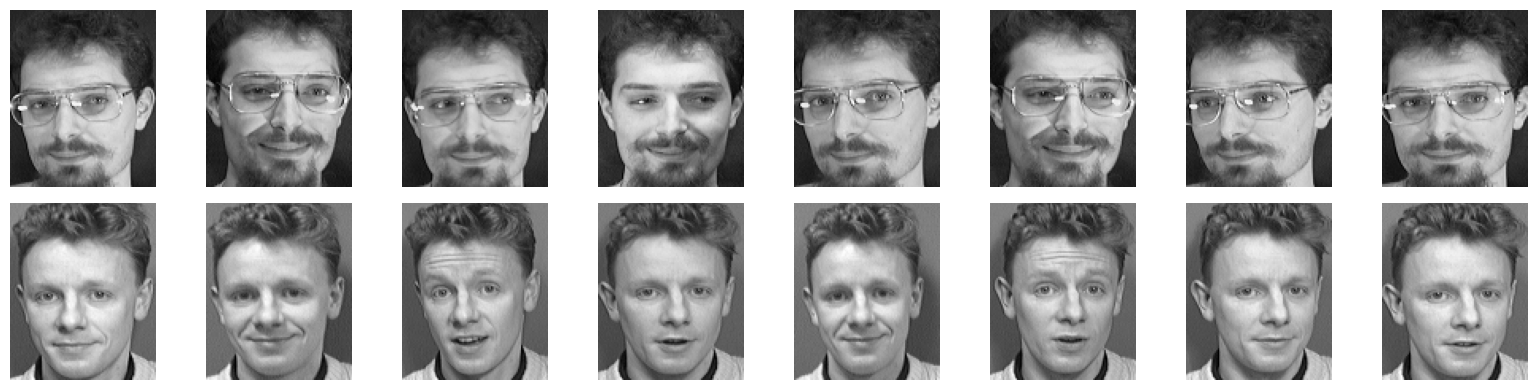

In [ ]:
ORL_data, ORL_labels, ORL_faceshape = read_ORL_UMIST_YALE_images("ORL")
print("ORL脸形状:", ORL_faceshape)
samplefaces(ORL_data.T, ORL_faceshape, ORL_labels, "ORL sample images 2x8")

YALE脸形状: (243, 320)
Selected labels: [14  5]


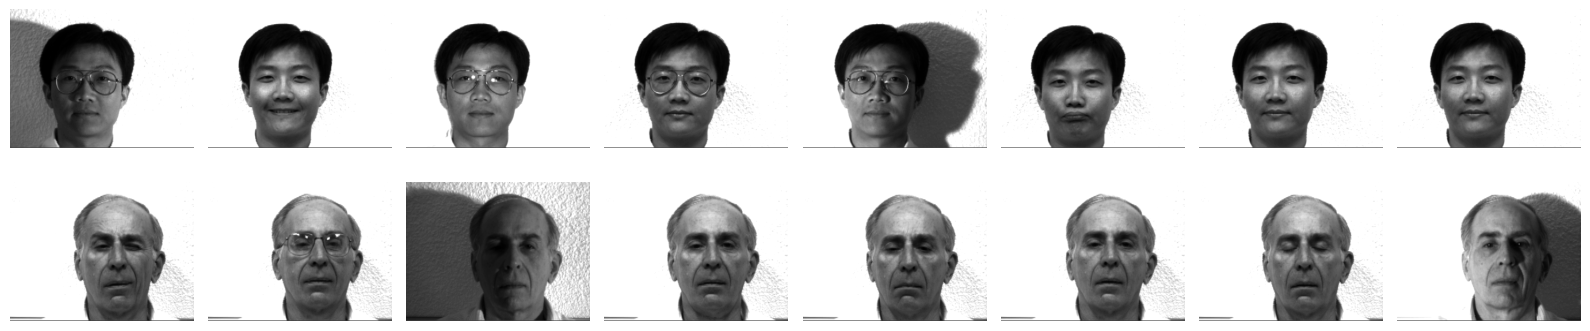

In [ ]:
YALE_data, YALE_labels, YALE_faceshape = read_ORL_UMIST_YALE_images("yalefaces")
print("YALE脸形状:", YALE_faceshape)
samplefaces(YALE_data.T, YALE_faceshape,YALE_labels, "YALE sample images 2x8")

Cropped_E_YaleB脸形状: (480, 640)
Selected labels: [28  5]


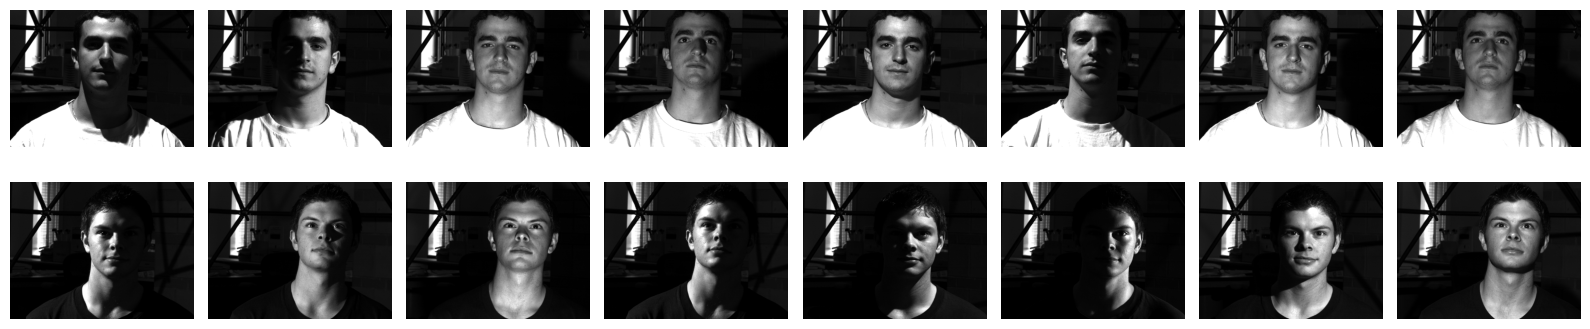

In [ ]:
Cropped_E_YaleB_data, Cropped_E_YaleB_labels, Cropped_E_YaleB_faceshape = read_ORL_UMIST_YALE_images("CroppedYaleB")
print("Cropped_E_YaleB脸形状:", Cropped_E_YaleB_faceshape)
samplefaces(Cropped_E_YaleB_data.T, Cropped_E_YaleB_faceshape, Cropped_E_YaleB_labels,"Cropped_E_YaleB sample images 2x8")